In [13]:
import os
import clip
import torch

import numpy as np
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
from tqdm import tqdm
import wandb
import argparse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.spatial import distance
from helpers.clip_transformations import *
from sklearn.decomposition import PCA

def get_features(dataset):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataset):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

In [2]:
import helpers.data_helpers as dh
DATASET_NAME = 'Waterbirds'

# load data
base_dataset, train_loader, val_loader = dh.get_dataset(DATASET_NAME, '/shared/group/ilsvrc',
                                                        batch_size=1, workers=8)

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)
train_features, train_labels = get_features(train_loader)
test_features, test_labels = get_features(val_loader)

WATERBIRDS DIR: /shared/lisabdunlap/vl-attention/data/waterbird_1.0_forest2water2
NUMBER OF SAMPLES WITH LABEL Landbird: 3694
NUMBER OF SAMPLES WITH LABEL Waterbird: 1101
NUMBER OF SAMPLES WITH GROUP Land_on_Land: 3694
NUMBER OF SAMPLES WITH GROUP Land_on_Water: 0
NUMBER OF SAMPLES WITH GROUP Water_on_Land: 0
NUMBER OF SAMPLES WITH GROUP Water_on_Water: 1101
WATERBIRDS DIR: /shared/lisabdunlap/vl-attention/data/waterbird_1.0_forest2water2
NUMBER OF SAMPLES WITH LABEL Landbird: 921
NUMBER OF SAMPLES WITH LABEL Waterbird: 278
NUMBER OF SAMPLES WITH GROUP Land_on_Land: 461
NUMBER OF SAMPLES WITH GROUP Land_on_Water: 460
NUMBER OF SAMPLES WITH GROUP Water_on_Land: 139
NUMBER OF SAMPLES WITH GROUP Water_on_Water: 139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1199/1199 [00:32<00:00, 36.58it/s]


In [3]:
train_labels.shape, train_features.shape

((4795,), (4795, 512))

In [4]:
bias_correction = BiasCorrection(["an image of a bird in the forest", "an image of a bird on the lake", "an image of a bird"], model)
data = bias_correction.calc_dist(train_features, train_labels)
data

,label,text,text id,sim
0,0,an image of a bird in the forest,0,0.297119
1,0,an image of a bird on the lake,1,0.261963
2,0,an image of a bird,2,0.273926
3,0,an image of a bird in the forest,0,0.257812
4,0,an image of a bird on the lake,1,0.255615
...,...,...,...,...
14380,0,an image of a bird on the lake,1,0.266846
14381,0,an image of a bird,2,0.265625
14382,0,an image of a bird in the forest,0,0.318848
14383,0,an image of a bird on the lake,1,0.295166


Text(0.5, 1.0, 'Waterbird')

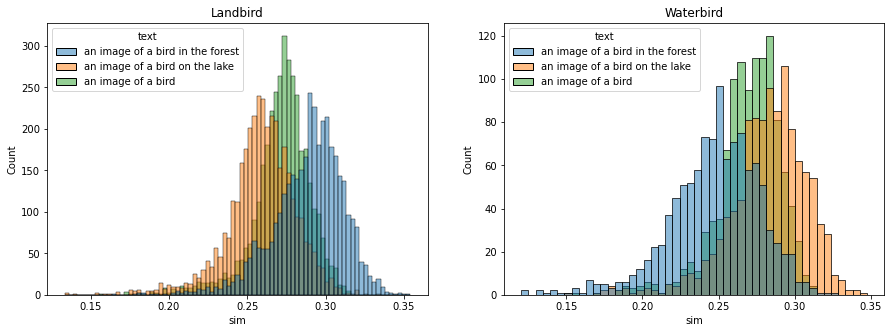

In [7]:
# data.groupby(["label", "text id"])["sim"].median()
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
sns.histplot(x='sim', hue='text', data=data[data['label'] == 0], ax=ax1)
ax1.set_title('Landbird')
sns.histplot(x='sim', hue='text', data=data[data['label'] == 1], ax=ax2)
ax2.set_title('Waterbird')

Text(0.5, 1.0, 'Waterbird')

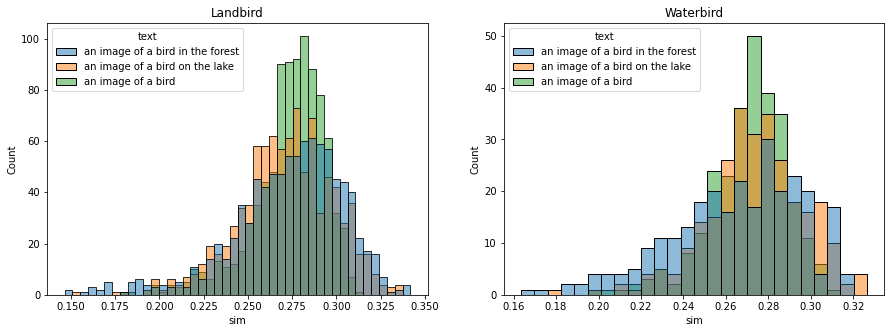

In [5]:
bias_correction = BiasCorrection(["an image of a bird in the forest", "an image of a bird on the lake", "an image of a bird"], model)
data = bias_correction.calc_dist(test_features, test_labels)
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
sns.histplot(x='sim', hue='text', data=data[data['label'] == 0], ax=ax1)
ax1.set_title('Landbird')
sns.histplot(x='sim', hue='text', data=data[data['label'] == 1], ax=ax2)
ax2.set_title('Waterbird')

<AxesSubplot:xlabel='sim', ylabel='Count'>

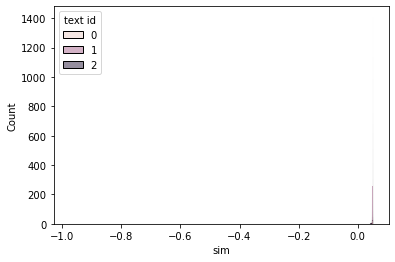

In [9]:
projected_emb = bias_correction.apply(train_features)
proj_data = bias_correction.calc_dist(projected_emb, train_labels)
sns.histplot(x='sim', hue='text id', data=proj_data[proj_data['label'] == 0])

In [10]:
proj_data

,label,text,text id,sim
0,0,an image of a bird in the forest,0,-0.965055
1,0,an image of a bird on the lake,1,-0.968423
2,0,an image of a bird,2,-0.977017
3,0,an image of a bird in the forest,0,-0.730540
4,0,an image of a bird on the lake,1,-0.734603
...,...,...,...,...
14380,0,an image of a bird on the lake,1,0.050067
14381,0,an image of a bird,2,0.051507
14382,0,an image of a bird in the forest,0,0.052197
14383,0,an image of a bird on the lake,1,0.050067


In [11]:
edited_embeddings = bias_correction.apply(train_features)
edited_data = bias_correction.calc_dist(edited_embeddings, train_labels)
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
sns.histplot(x='sim', hue='text', data=edited_data[edited_data['label'] == 0], ax=ax1)
ax1.set_title('Landbird')
sns.histplot(x='sim', hue='text', data=edited_data[edited_data['label'] == 1], ax=ax2)
ax2.set_title('Waterbird')
edited_data

,label,text,text id,sim
0,0,an image of a bird in the forest,0,-0.965055
1,0,an image of a bird on the lake,1,-0.968423
2,0,an image of a bird,2,-0.977017
3,1,an image of a bird in the forest,0,-0.730540
4,1,an image of a bird on the lake,1,-0.734603
...,...,...,...,...
14380,1,an image of a bird on the lake,1,0.050067
14381,1,an image of a bird,2,0.051507
14382,0,an image of a bird in the forest,0,0.052197
14383,0,an image of a bird on the lake,1,0.050067


In [16]:
# (np.dot(a, b) / np.dot(b, b)) * b
land_emb, water_emb = bias_correction.text_embeddings
projected_emb = []
for i in range(train_features.shape[0]):
    a = train_features[i]
    b = land_emb
    land_proj = (np.dot(a, b) / np.dot(b, b)) * b
    c = water_emb
    water_proj = (np.dot(a, c) / np.dot(c, c)) * c
    projected_emb.append(np.abs(land_proj - water_proj))

projected_emb = np.array(projected_emb)

In [17]:
proj_data = bias_correction.calc_dist(projected_emb, train_labels)
proj_data

,label,text,text id,sim
0,0,an image of a forest,0,0.206421
1,0,an image of a lake,1,0.214600
2,0,an image of a forest,0,0.295410
3,0,an image of a lake,1,0.300049
4,1,an image of a forest,0,0.196045
...,...,...,...,...
2319,0,an image of a lake,1,0.233521
2320,0,an image of a forest,0,0.196533
2321,0,an image of a lake,1,0.205078
2322,1,an image of a forest,0,0.287598


<AxesSubplot:xlabel='sim', ylabel='Count'>

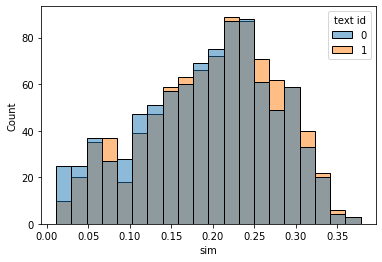

In [18]:
sns.histplot(x='sim', hue='text id', data=proj_data[proj_data['label'] == 0])

<AxesSubplot:xlabel='sim', ylabel='Count'>

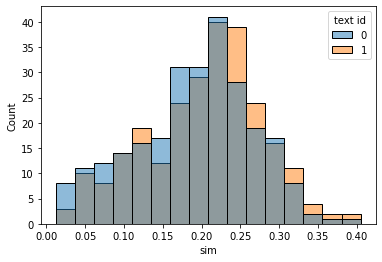

In [19]:
sns.histplot(x='sim', hue='text id', data=proj_data[proj_data['label'] == 1])

## Sentance Debias with CLIP

In [25]:
import clip 

prompts = ["a photo of", "an image of"]
D = [('land', 'water'), ('a forest', 'a lake'), ('a tundra', 'a ocean')]
land_prompts = "a photo of land", "an image of land", "a photo of a forest", "an image of a forest"
water_prompts = "a photo of water", "an image of water", "a photo of a lake", "an image of a lake"

def get_embedding(prompts):
    text_inputs = torch.cat([clip.tokenize(t) for t in prompts]).cuda()
    # Calculate features
    with torch.no_grad():
        text_features = model.encode_text(text_inputs)
    return text_features.cpu().numpy()

In [26]:
land_emb = get_embedding(land_prompts)
water_emb = get_embedding(water_prompts)
water_emb

array([[-0.09015,  0.3032 ,  0.201  , ..., -0.446  ,  0.1283 ,  0.02065],
       [-0.0779 ,  0.364  ,  0.2883 , ..., -0.374  ,  0.2612 , -0.1608 ],
       [ 0.2832 ,  0.4158 ,  0.4255 , ..., -0.5337 , -0.2284 , -0.05075],
       [ 0.3013 ,  0.407  ,  0.4678 , ..., -0.4504 , -0.1218 , -0.1124 ]],
      dtype=float16)

In [27]:
bias_vectors = np.array([l - np.mean(land_emb, axis=0) for l in land_emb] + [w-np.mean(water_emb, axis=0) for w in water_emb])
bias_vectors.shape

(8, 512)

In [30]:
from sklearn.decomposition import PCA

pca = PCA(n_components=, svd_solver='full')
pca.fit(bias_vectors)

PCA(n_components=2, svd_solver='full')

In [34]:
pca.components_

array([[ 0.02659372, -0.02104206,  0.02311246, ...,  0.00917546,
        -0.06116743,  0.11125383],
       [-0.07777725, -0.0329211 , -0.03592039, ...,  0.02715073,
         0.05476361,  0.07304348]])

In [4]:
class SentenceDebias:
    from sklearn.decomposition import PCA

    def __init__(self, prompts, model, k=2):
        # WARNING: prompts should be a list of lists
        self.prompts = prompts
        self.model = model
        self.d = len(self.prompts[0])
        self.embs = []
        self.bias_vectors = []
        for i in range(len(self.prompts)):
            print(self.prompts[i])
            emb = self.get_embedding(self.prompts[i])
            self.embs.append(emb)
            self.bias_vectors += [v - np.mean(emb, axis=0) for v in emb]
        pca = PCA(n_components=k, svd_solver='full')
        pca.fit(self.bias_vectors)
        self.bias_space = pca.components_

    @staticmethod
    def get_embedding(prompts):
        text_inputs = torch.cat([clip.tokenize(t) for t in prompts]).cuda()
        # Calculate features
        with torch.no_grad():
            text_features = model.encode_text(text_inputs)
        return text_features.cpu().numpy()

    def apply(self, inputs):
        ret = []
        for h in inputs:
            h_v = np.sum([(np.dot(h, b) / np.dot(b, b)) * b for b in self.bias_space], axis=0)
            ret.append(h - h_v)
        return np.array(ret)
        

In [7]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)
land_prompts = ["a photo of land", "an image of land", "a photo of a forest", "an image of a forest"]
water_prompts = ["a photo of water", "an image of water", "a photo of a lake", "an image of a lake"]
sent_bias = SentenceDebias([land_prompts, water_prompts], model)
debias_features = sent_bias.apply(train_features)

['a photo of land', 'an image of land', 'a photo of a forest', 'an image of a forest']
['a photo of water', 'an image of water', 'a photo of a lake', 'an image of a lake']


In [9]:
bias_correction = BiasCorrection(["an image of a forest", "an image of a lake"], model)
data = bias_correction.calc_dist(debias_features, train_labels)

Text(0.5, 1.0, 'Waterbird')

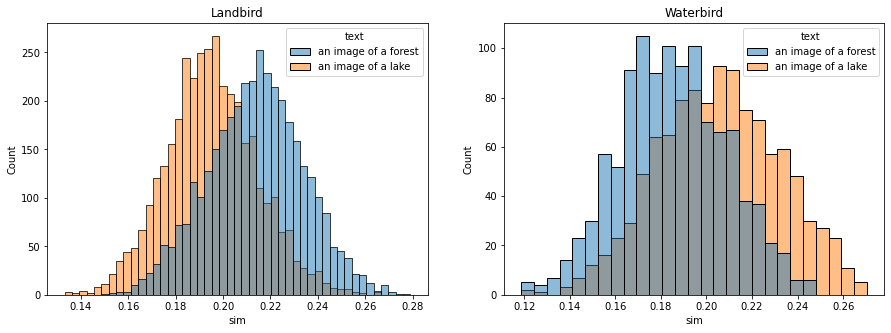

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
sns.histplot(x='sim', hue='text', data=data[data['label'] == 0], ax=ax1)
ax1.set_title('Landbird')
sns.histplot(x='sim', hue='text', data=data[data['label'] == 1], ax=ax2)
ax2.set_title('Waterbird')

## Project

Text(0.5, 1.0, 'Waterbird')

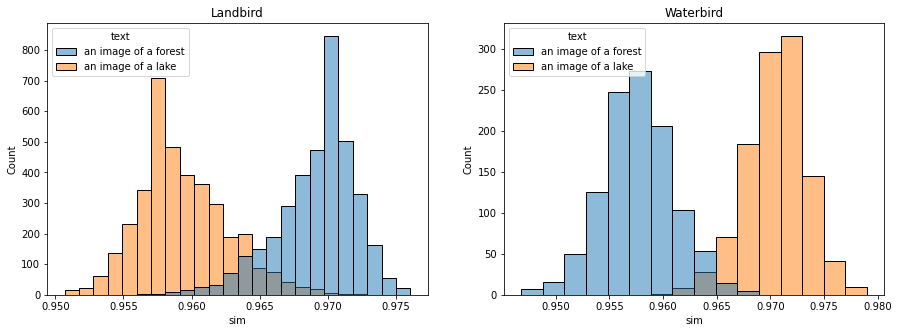

In [14]:
bias_correction = Project(["an image of a forest", "an image of a lake"], model)
proj = bias_correction.apply(train_features)
data = bias_correction.calc_dist(proj, train_labels)
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
sns.histplot(x='sim', hue='text', data=data[data['label'] == 0], ax=ax1)
ax1.set_title('Landbird')
sns.histplot(x='sim', hue='text', data=data[data['label'] == 1], ax=ax2)
ax2.set_title('Waterbird')

Text(0.5, 1.0, 'Waterbird')

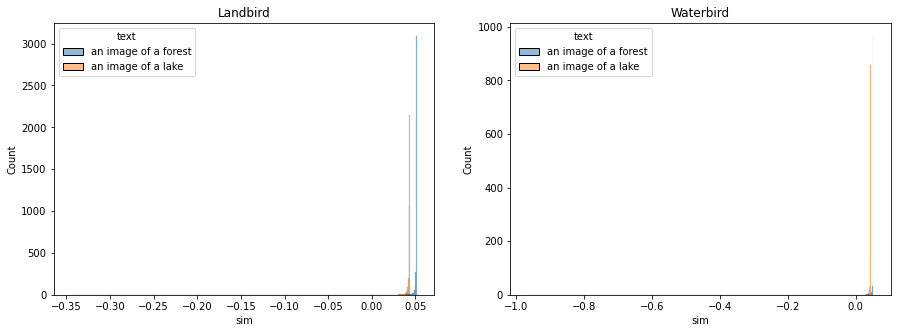

In [15]:
bias_correction = BiasCorrection(["an image of a forest", "an image of a lake"], model)
proj = bias_correction.apply(train_features)
data = bias_correction.calc_dist(proj, train_labels)
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
sns.histplot(x='sim', hue='text', data=data[data['label'] == 0], ax=ax1)
ax1.set_title('Landbird')
sns.histplot(x='sim', hue='text', data=data[data['label'] == 1], ax=ax2)
ax2.set_title('Waterbird')